<a href="https://colab.research.google.com/github/amankiitg/5DParallel/blob/main/ShallowSpeed_GPU_Benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ShallowSpeed on GPU: Data-Parallel Training Benchmarks

A PyTorch GPU implementation of the distributed training concepts from [siboehm/ShallowSpeed](https://github.com/siboehm/shallowspeed).

## What We Benchmark

| # | Mode | Description |
|---|------|-------------|
| 1 | **Single GPU (Baseline)** | Standard training on 1 GPU. No communication. |
| 2 | **DP Naive (Non-Interleaved)** | N GPUs. Full forward + full backward, **then** blocking AllReduce on all gradients. Computation and communication are **separate phases**. |
| 3 | **DP Interleaved** | N GPUs. During backward pass, **non-blocking AllReduce fires per layer** as soon as its gradient is ready. Communication **overlaps** with computation. |
| 4 | **PyTorch DDP (Reference)** | PyTorch's built-in `DistributedDataParallel` — production-grade interleaved DP with bucketed AllReduce. |

```
NAIVE:
  [====== FWD ======][====== BWD ======][=== AllReduce ALL grads ===][Update]
       GPU compute        GPU compute        NCCL busy, GPU idle

INTERLEAVED:
  [=== FWD ===][ BWD_L6 + AllReduce(L6) ][ BWD_L5 + AllReduce(L5) ][ ... ][Update]
                ^^^^^^^^ GPU compute + NCCL overlap ^^^^^^^^^^^^^^^^^^

PyTorch DDP:
  Same as interleaved, but with gradient bucketing for fewer AllReduce calls.
```

## Hardware Requirements
- **RunPod**: 2 or 4 GPUs (e.g. 2x A100, 4x A100, 2x RTX 4090, etc.)
- Works on any multi-GPU machine with NCCL support

---
## 1. Environment Check

In [ ]:
import torch
import os

NUM_GPUS = torch.cuda.device_count()
print(f"PyTorch version : {torch.__version__}")
print(f"CUDA available  : {torch.cuda.is_available()}")
print(f"NCCL available  : {torch.distributed.is_nccl_available()}")
print(f"GPUs found      : {NUM_GPUS}")
for i in range(NUM_GPUS):
    props = torch.cuda.get_device_properties(i)
    mem = getattr(props, 'total_memory', getattr(props, 'total_mem', 0)) / 1024**3
    print(f"  GPU {i}: {props.name} ({mem:.1f} GB)")

if NUM_GPUS < 2:
    print("\n⚠️  Only 1 GPU detected. Data-parallel benchmarks need >= 2 GPUs.")
    print("    On RunPod, select a pod template with 2+ GPUs.")
    print("    The single-GPU baseline will still run.")

PyTorch version : 2.4.1+cu124
CUDA available  : True
NCCL available  : True
GPUs found      : 2
  GPU 0: NVIDIA A100 80GB PCIe (79.3 GB)
  GPU 1: NVIDIA A100 80GB PCIe (79.3 GB)


---
## 2. Write the Training Scripts

We write 4 standalone scripts that `torchrun` launches as separate processes (one per GPU).

### 2a. Shared Model & Dataset

In [ ]:
%%writefile model_common.py
"""
Shared model definition and dataset — used by all training scripts.

We use a deep MLP (like ShallowSpeed) but sized for GPUs.
The model is deliberately deep (many layers) so that interleaved
AllReduce has many opportunities to overlap with backward computation.
"""
import torch
import torch.nn as nn


def build_model(size='medium'):
    """
    Build a deep MLP — the same type of sequential model ShallowSpeed uses.
    Deeper models benefit more from interleaved AllReduce because there are
    more layers whose gradient computation can overlap with communication.
    """
    configs = {
        'small': [784, 1024, 512, 256, 10],                              # ~1.2M params
        'medium': [784, 2048, 2048, 1024, 512, 10],                      # ~7.2M params
        'large': [784, 4096, 4096, 2048, 2048, 1024, 512, 10],           # ~35M params
        'xlarge': [784, 4096, 4096, 4096, 2048, 2048, 1024, 512, 10],    # ~52M params
    }
    sizes = configs[size]
    layers = []
    for i in range(len(sizes) - 1):
        layers.append(nn.Linear(sizes[i], sizes[i + 1]))
        if i < len(sizes) - 2:
            layers.append(nn.ReLU())
    model = nn.Sequential(*layers)

    n_params = sum(p.numel() for p in model.parameters())
    return model, n_params


def make_dataset(n_samples=32768, n_features=784, n_classes=10):
    """
    Synthetic MNIST-shaped dataset. Large enough to saturate GPU.
    All ranks generate the same data (same seed) then each takes its shard.
    """
    torch.manual_seed(42)
    X = torch.randn(n_samples, n_features)
    y = torch.randint(0, n_classes, (n_samples,))
    return X, y


def count_params(model):
    return sum(p.numel() for p in model.parameters())


print("model_common.py loaded OK")
for sz in ['small', 'medium', 'large', 'xlarge']:
    _, n = build_model(sz)
    print(f"  {sz:8s}: {n:>12,} params")

Overwriting model_common.py


### 2b. Single GPU Baseline (No Parallelism)

In [ ]:
%%writefile train_single_gpu.py
"""
SINGLE GPU BASELINE
====================
Standard training loop on 1 GPU. No communication.
This is the baseline that all parallel methods are compared against.
"""
import torch, torch.nn as nn, time, json, sys, os
from model_common import build_model, make_dataset

def main():
    config = json.loads(sys.argv[1])
    device = torch.device('cuda:0')

    model, n_params = build_model(config['model_size'])
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'])
    loss_fn = nn.CrossEntropyLoss()

    X, y = make_dataset(config['n_samples'])
    X, y = X.to(device), y.to(device)
    bs = config['batch_size']

    # Warmup
    for _ in range(3):
        idx = torch.randint(0, len(X), (bs,))
        out = model(X[idx])
        loss_fn(out, y[idx]).backward()
        optimizer.zero_grad()
    torch.cuda.synchronize()

    epoch_times, losses = [], []
    for epoch in range(config['n_epochs']):
        torch.cuda.synchronize()
        t0 = time.perf_counter()
        epoch_loss, nb = 0.0, 0

        for start in range(0, len(X), bs):
            xb = X[start:start+bs]
            yb = y[start:start+bs]
            optimizer.zero_grad()
            out = model(xb)
            loss = loss_fn(out, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item(); nb += 1

        torch.cuda.synchronize()
        epoch_times.append(time.perf_counter() - t0)
        losses.append(epoch_loss / nb)

    # Accuracy
    model.eval()
    with torch.no_grad():
        correct = 0
        for start in range(0, len(X), bs):
            out = model(X[start:start+bs])
            correct += (out.argmax(1) == y[start:start+bs]).sum().item()
    acc = correct / len(X)

    print('RESULTS_JSON:' + json.dumps({
        'mode': 'single_gpu', 'n_gpus': 1, 'n_params': n_params,
        'model_size': config['model_size'],
        'epoch_times': epoch_times, 'losses': losses,
        'final_accuracy': acc,
        'avg_epoch_time': sum(epoch_times) / len(epoch_times),
        'total_time': sum(epoch_times),
        'comm_time': 0.0,
    }))

if __name__ == '__main__':
    main()

Overwriting train_single_gpu.py


### 2c. Naive Data-Parallel (Non-Interleaved AllReduce)

This is the straightforward approach ShallowSpeed describes first:
```python
# Full forward + backward, THEN sync everything
loss.backward()   # compute ALL gradients
for param in model.parameters():
    dist.all_reduce(param.grad)   # BLOCKING — GPU waits
optimizer.step()
```

In [ ]:
%%writefile train_dp_naive.py
"""
DATA-PARALLEL: NAIVE (NON-INTERLEAVED)
=======================================
Each GPU gets a shard of the batch.
Full forward pass → Full backward pass → THEN AllReduce ALL gradients.

Communication and computation are COMPLETELY SEPARATE PHASES:
  [=== FWD ===][=== BWD ===][=== AllReduce ALL grads (GPU idle) ===][Update]

This is what ShallowSpeed calls the 'straightforward' (suboptimal) approach:
  'This is suboptimal since it divides our training into two stages.
   During the first stage (forward & backward pass) we're waiting for the
   processors to finish computing, while our network is doing nothing.
   During the second stage (AllReduce) our network is communicating as
   fast as possible, while the processors are twiddling their fans.'
"""
import torch, torch.nn as nn, torch.distributed as dist
import time, json, sys, os
from model_common import build_model, make_dataset

def main():
    # --- Setup distributed ---
    dist.init_process_group(backend='nccl')
    rank = dist.get_rank()
    world_size = dist.get_world_size()
    device = torch.device(f'cuda:{rank}')
    torch.cuda.set_device(device)

    config = json.loads(sys.argv[1])

    # All ranks build SAME model (same seed), then put on their own GPU
    torch.manual_seed(42)
    model, n_params = build_model(config['model_size'])
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'])
    loss_fn = nn.CrossEntropyLoss()

    # Each rank loads full dataset, then takes its shard per batch
    X_all, y_all = make_dataset(config['n_samples'])
    X_all, y_all = X_all.to(device), y_all.to(device)
    bs = config['batch_size']

    # Warmup
    for _ in range(3):
        idx = torch.randint(0, len(X_all), (bs // world_size,))
        out = model(X_all[idx])
        loss_fn(out, y_all[idx]).backward()
        optimizer.zero_grad()
    torch.cuda.synchronize()
    dist.barrier()

    epoch_times, losses, comm_times = [], [], []
    for epoch in range(config['n_epochs']):
        torch.cuda.synchronize()
        dist.barrier()
        t0 = time.perf_counter()
        epoch_loss, nb, epoch_comm = 0.0, 0, 0.0

        for start in range(0, len(X_all), bs):
            xb = X_all[start:start+bs]
            yb = y_all[start:start+bs]

            # Shard the batch across GPUs
            chunk = len(xb) // world_size
            s = rank * chunk
            e = s + chunk if rank < world_size - 1 else len(xb)
            x_local, y_local = xb[s:e], yb[s:e]

            # === COMPUTATION PHASE: full forward + backward ===
            optimizer.zero_grad()
            out = model(x_local)
            loss = loss_fn(out, y_local)
            loss.backward()   # ALL gradients computed

            # === COMMUNICATION PHASE: AllReduce ALL gradients (BLOCKING) ===
            torch.cuda.synchronize()
            tc0 = time.perf_counter()

            for param in model.parameters():
                if param.grad is not None:
                    dist.all_reduce(param.grad, op=dist.ReduceOp.SUM)
                    param.grad /= world_size

            torch.cuda.synchronize()
            epoch_comm += time.perf_counter() - tc0

            # === WEIGHT UPDATE ===
            optimizer.step()
            epoch_loss += loss.item(); nb += 1

        torch.cuda.synchronize()
        epoch_times.append(time.perf_counter() - t0)
        losses.append(epoch_loss / max(nb, 1))
        comm_times.append(epoch_comm)

    # Accuracy
    model.eval()
    with torch.no_grad():
        correct = 0
        for start in range(0, len(X_all), bs):
            out = model(X_all[start:start+bs])
            correct += (out.argmax(1) == y_all[start:start+bs]).sum().item()
    acc = correct / len(X_all)

    if rank == 0:
        print('RESULTS_JSON:' + json.dumps({
            'mode': 'dp_naive', 'n_gpus': world_size, 'n_params': n_params,
            'model_size': config['model_size'],
            'epoch_times': epoch_times, 'losses': losses,
            'comm_times': comm_times,
            'final_accuracy': acc,
            'avg_epoch_time': sum(epoch_times) / len(epoch_times),
            'avg_comm_time': sum(comm_times) / len(comm_times),
            'total_time': sum(epoch_times),
            'comm_time': sum(comm_times),
        }))

    dist.destroy_process_group()

if __name__ == '__main__':
    main()

Overwriting train_dp_naive.py


### 2d. Interleaved Data-Parallel (Non-blocking AllReduce During Backward)

This is the optimized approach from ShallowSpeed:
```python
# ShallowSpeed's approach — fire AllReduce per layer during backward:
def backprop_allreduce_gradient(comm, param):
    param._request = comm.Iallreduce(MPI.IN_PLACE, param.grad, op=MPI.SUM)
autograd.register_grad_hook(backprop_allreduce_gradient)
```
We implement the same thing with PyTorch's `register_post_accumulate_grad_hook`.

In [ ]:
%%writefile train_dp_interleaved.py
"""
DATA-PARALLEL: INTERLEAVED (Non-blocking AllReduce during backward)
====================================================================
Same as ShallowSpeed's interleaved implementation:
  - Register a gradient hook on each parameter.
  - When a param's gradient is ready, immediately fire async AllReduce.
  - While NCCL transfers that layer's gradients, the GPU is computing
    gradients for the previous layer.
  - Before optimizer.step(), wait for all AllReduces to finish.

Timeline:
  [FWD][BWD_L6 + AllReduce(L6)][BWD_L5 + AllReduce(L5)][...][Wait][Update]
         ^^^^^^ computation + communication overlap ^^^^^^^^^
"""
import torch, torch.nn as nn, torch.distributed as dist
import time, json, sys, os
from model_common import build_model, make_dataset


class InterleavedDP:
    """
    Wraps a model to perform interleaved AllReduce during backward.
    Mirrors ShallowSpeed's grad hook approach.
    """
    def __init__(self, model, world_size):
        self.model = model
        self.world_size = world_size
        self._handles = []  # async AllReduce handles

        # Register hooks on every parameter — exactly like ShallowSpeed:
        #   autograd.register_grad_hook(backprop_allreduce_gradient)
        for param in self.model.parameters():
            param.register_post_accumulate_grad_hook(self._make_hook(param))

    def _make_hook(self, param):
        def hook(p):
            # Fire non-blocking AllReduce as soon as this gradient is ready
            handle = dist.all_reduce(p.grad, op=dist.ReduceOp.SUM, async_op=True)
            self._handles.append((handle, p))
        return hook

    def finish_allreduce(self):
        """
        Wait for all async AllReduces. Mirrors ShallowSpeed's:
          MPI.Request.Waitall(requests)
        """
        for handle, param in self._handles:
            handle.wait()
            param.grad /= self.world_size
        self._handles.clear()


def main():
    dist.init_process_group(backend='nccl')
    rank = dist.get_rank()
    world_size = dist.get_world_size()
    device = torch.device(f'cuda:{rank}')
    torch.cuda.set_device(device)

    config = json.loads(sys.argv[1])

    torch.manual_seed(42)
    model, n_params = build_model(config['model_size'])
    model = model.to(device)
    dp = InterleavedDP(model, world_size)
    optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'])
    loss_fn = nn.CrossEntropyLoss()

    X_all, y_all = make_dataset(config['n_samples'])
    X_all, y_all = X_all.to(device), y_all.to(device)
    bs = config['batch_size']

    # Warmup
    for _ in range(3):
        idx = torch.randint(0, len(X_all), (bs // world_size,))
        out = model(X_all[idx])
        loss_fn(out, y_all[idx]).backward()
        dp.finish_allreduce()
        optimizer.zero_grad()
    torch.cuda.synchronize()
    dist.barrier()

    epoch_times, losses, comm_times = [], [], []
    for epoch in range(config['n_epochs']):
        torch.cuda.synchronize()
        dist.barrier()
        t0 = time.perf_counter()
        epoch_loss, nb = 0.0, 0

        for start in range(0, len(X_all), bs):
            xb = X_all[start:start+bs]
            yb = y_all[start:start+bs]

            chunk = len(xb) // world_size
            s = rank * chunk
            e = s + chunk if rank < world_size - 1 else len(xb)
            x_local, y_local = xb[s:e], yb[s:e]

            optimizer.zero_grad()
            out = model(x_local)
            loss = loss_fn(out, y_local)

            # === INTERLEAVED: backward fires async AllReduce per layer via hooks ===
            loss.backward()

            # Wait for all async AllReduces to complete
            dp.finish_allreduce()

            optimizer.step()
            epoch_loss += loss.item(); nb += 1

        torch.cuda.synchronize()
        epoch_times.append(time.perf_counter() - t0)
        losses.append(epoch_loss / max(nb, 1))

    # Accuracy
    model.eval()
    with torch.no_grad():
        correct = 0
        for start in range(0, len(X_all), bs):
            out = model(X_all[start:start+bs])
            correct += (out.argmax(1) == y_all[start:start+bs]).sum().item()
    acc = correct / len(X_all)

    if rank == 0:
        print('RESULTS_JSON:' + json.dumps({
            'mode': 'dp_interleaved', 'n_gpus': world_size, 'n_params': n_params,
            'model_size': config['model_size'],
            'epoch_times': epoch_times, 'losses': losses,
            'final_accuracy': acc,
            'avg_epoch_time': sum(epoch_times) / len(epoch_times),
            'total_time': sum(epoch_times),
        }))

    dist.destroy_process_group()

if __name__ == '__main__':
    main()

Overwriting train_dp_interleaved.py


### 2e. PyTorch DDP (Reference — Production-Grade Interleaved)

PyTorch's built-in `DistributedDataParallel` is the production version of interleaved AllReduce. It adds **gradient bucketing**: instead of one AllReduce per layer, it groups small gradients into buckets and does fewer, larger AllReduces. This reduces NCCL launch overhead.

In [ ]:
%%writefile train_ddp_builtin.py
"""
PyTorch DDP (REFERENCE)
========================
Uses torch.nn.parallel.DistributedDataParallel.
This is the production-grade interleaved AllReduce with bucketing.
Serves as the gold standard to compare our manual implementations against.
"""
import torch, torch.nn as nn, torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
import time, json, sys, os
from model_common import build_model, make_dataset

def main():
    dist.init_process_group(backend='nccl')
    rank = dist.get_rank()
    world_size = dist.get_world_size()
    device = torch.device(f'cuda:{rank}')
    torch.cuda.set_device(device)

    config = json.loads(sys.argv[1])

    torch.manual_seed(42)
    model, n_params = build_model(config['model_size'])
    model = model.to(device)
    # Wrap with DDP — this handles interleaved AllReduce + bucketing internally
    model = DDP(model, device_ids=[rank])
    optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'])
    loss_fn = nn.CrossEntropyLoss()

    X_all, y_all = make_dataset(config['n_samples'])
    X_all, y_all = X_all.to(device), y_all.to(device)
    bs = config['batch_size']

    # Warmup
    for _ in range(3):
        idx = torch.randint(0, len(X_all), (bs // world_size,))
        out = model(X_all[idx])
        loss_fn(out, y_all[idx]).backward()
        optimizer.zero_grad()
    torch.cuda.synchronize()
    dist.barrier()

    epoch_times, losses = [], []
    for epoch in range(config['n_epochs']):
        torch.cuda.synchronize()
        dist.barrier()
        t0 = time.perf_counter()
        epoch_loss, nb = 0.0, 0

        for start in range(0, len(X_all), bs):
            xb = X_all[start:start+bs]
            yb = y_all[start:start+bs]

            chunk = len(xb) // world_size
            s = rank * chunk
            e = s + chunk if rank < world_size - 1 else len(xb)
            x_local, y_local = xb[s:e], yb[s:e]

            optimizer.zero_grad()
            out = model(x_local)
            loss = loss_fn(out, y_local)
            # DDP handles AllReduce automatically during backward
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item(); nb += 1

        torch.cuda.synchronize()
        epoch_times.append(time.perf_counter() - t0)
        losses.append(epoch_loss / max(nb, 1))

    # Accuracy
    model.eval()
    with torch.no_grad():
        correct = 0
        for start in range(0, len(X_all), bs):
            out = model(X_all[start:start+bs])
            correct += (out.argmax(1) == y_all[start:start+bs]).sum().item()
    acc = correct / len(X_all)

    if rank == 0:
        print('RESULTS_JSON:' + json.dumps({
            'mode': 'ddp_builtin', 'n_gpus': world_size, 'n_params': n_params,
            'model_size': config['model_size'],
            'epoch_times': epoch_times, 'losses': losses,
            'final_accuracy': acc,
            'avg_epoch_time': sum(epoch_times) / len(epoch_times),
            'total_time': sum(epoch_times),
        }))

    dist.destroy_process_group()

if __name__ == '__main__':
    main()

Overwriting train_ddp_builtin.py


---
## 3. Benchmark Runner

Runs all configurations and collects results.

In [ ]:
%%writefile run_benchmarks.py
import subprocess, json, sys, os, torch

NUM_GPUS = torch.cuda.device_count()
print(f"Detected {NUM_GPUS} GPUs")

def run(cmd):
    print(f"  CMD: {' '.join(cmd[:6])}...")
    r = subprocess.run(cmd, capture_output=True, text=True, timeout=600)
    if r.returncode != 0:
        print(f"  ERROR (rc={r.returncode}): {r.stderr[:300]}")
        return None
    for line in r.stdout.split('\n'):
        if line.startswith('RESULTS_JSON:'):
            return json.loads(line[len('RESULTS_JSON:'):])
    print(f"  No RESULTS_JSON. stdout: {r.stdout[:200]}")
    return None


base = {
    'n_samples': 32768,
    'batch_size': 1024,
    'lr': 0.01,
    'n_epochs': 5,
}

model_sizes = ['small', 'medium', 'large']
if NUM_GPUS >= 4:
    model_sizes.append('xlarge')   # only run XL if we have 4 GPUs

gpu_counts = [g for g in [2, 4] if g <= NUM_GPUS]
all_results = []

for msz in model_sizes:
    cfg = {**base, 'model_size': msz}
    cfg_str = json.dumps(cfg)
    print(f"\n{'='*60}")
    print(f"Model: {msz}")
    print(f"{'='*60}")

    # --- Single GPU baseline ---
    print(f"\n  [1] Single GPU baseline...")
    r = run(['python', 'train_single_gpu.py', cfg_str])
    if r: all_results.append(r); print(f"    avg_epoch={r['avg_epoch_time']:.4f}s")

    for ng in gpu_counts:
        tr = ['torchrun', '--nproc_per_node', str(ng), '--master_port',
              str(29500 + len(all_results))]

        # --- Naive DP ---
        print(f"\n  [2] DP Naive, {ng} GPUs...")
        r = run(tr + ['train_dp_naive.py', cfg_str])
        if r: all_results.append(r); print(f"    avg_epoch={r['avg_epoch_time']:.4f}s, comm={r.get('avg_comm_time',0):.4f}s")

        # --- Interleaved DP ---
        print(f"\n  [3] DP Interleaved, {ng} GPUs...")
        r = run(tr + ['train_dp_interleaved.py', cfg_str])
        if r: all_results.append(r); print(f"    avg_epoch={r['avg_epoch_time']:.4f}s")

        # --- PyTorch DDP ---
        print(f"\n  [4] PyTorch DDP, {ng} GPUs...")
        r = run(tr + ['train_ddp_builtin.py', cfg_str])
        if r: all_results.append(r); print(f"    avg_epoch={r['avg_epoch_time']:.4f}s")

with open('benchmark_results.json', 'w') as f:
    json.dump(all_results, f, indent=2)
print(f"\n\nDone! {len(all_results)} results saved.")

Overwriting run_benchmarks.py


In [ ]:
!python run_benchmarks.py

Detected 2 GPUs

Model: small

  [1] Single GPU baseline...
  CMD: python train_single_gpu.py {"n_samples": 32768, "batch_size": 1024, "lr": 0.01, "n_epochs": 5, "model_size": "small"}...
    avg_epoch=0.0294s

  [2] DP Naive, 2 GPUs...
  CMD: torchrun --nproc_per_node 2 --master_port 29501 train_dp_naive.py...
    avg_epoch=0.0438s, comm=0.0168s

  [3] DP Interleaved, 2 GPUs...
  CMD: torchrun --nproc_per_node 2 --master_port 29501 train_dp_interleaved.py...
    avg_epoch=0.0447s

  [4] PyTorch DDP, 2 GPUs...
  CMD: torchrun --nproc_per_node 2 --master_port 29501 train_ddp_builtin.py...
    avg_epoch=0.0370s

Model: medium

  [1] Single GPU baseline...
  CMD: python train_single_gpu.py {"n_samples": 32768, "batch_size": 1024, "lr": 0.01, "n_epochs": 5, "model_size": "medium"}...
    avg_epoch=0.1117s

  [2] DP Naive, 2 GPUs...
  CMD: torchrun --nproc_per_node 2 --master_port 29505 train_dp_naive.py...
    avg_epoch=0.0942s, comm=0.0236s

  [3] DP Interleaved, 2 GPUs...
  CMD: torchrun

---
## 4. Visualize Results

In [ ]:
import json, numpy as np, matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 130
matplotlib.rcParams['font.size'] = 10

with open('benchmark_results.json') as f:
    results = json.load(f)

print(f"Loaded {len(results)} results:\n")
print(f"{'Model':<8} {'Mode':<20} {'GPUs':>4} {'Params':>12} {'Avg Epoch':>10} {'Accuracy':>8}")
print('─' * 70)
for r in results:
    print(f"{r['model_size']:<8} {r['mode']:<20} {r['n_gpus']:>4} "
          f"{r['n_params']:>12,} {r['avg_epoch_time']:>9.4f}s {r['final_accuracy']:>7.4f}")

Loaded 12 results:

Model    Mode                 GPUs       Params  Avg Epoch Accuracy
──────────────────────────────────────────────────────────────────────
small    single_gpu              1    1,462,538    0.0294s  0.1022
small    dp_naive                2    1,462,538    0.0438s  0.1013
small    dp_interleaved          2    1,462,538    0.0447s  0.1013
small    ddp_builtin             2    1,462,538    0.0370s  0.1013
medium   single_gpu              1    8,432,138    0.1117s  0.1007
medium   dp_naive                2    8,432,138    0.0942s  0.1046
medium   dp_interleaved          2    8,432,138    0.0770s  0.1046
medium   ddp_builtin             2    8,432,138    0.0783s  0.1046
large    single_gpu              1   35,211,786    0.4211s  0.0989
large    dp_naive                2   35,211,786    0.2837s  0.1004
large    dp_interleaved          2   35,211,786    0.2623s  0.1004
large    ddp_builtin             2   35,211,786    0.2615s  0.1004


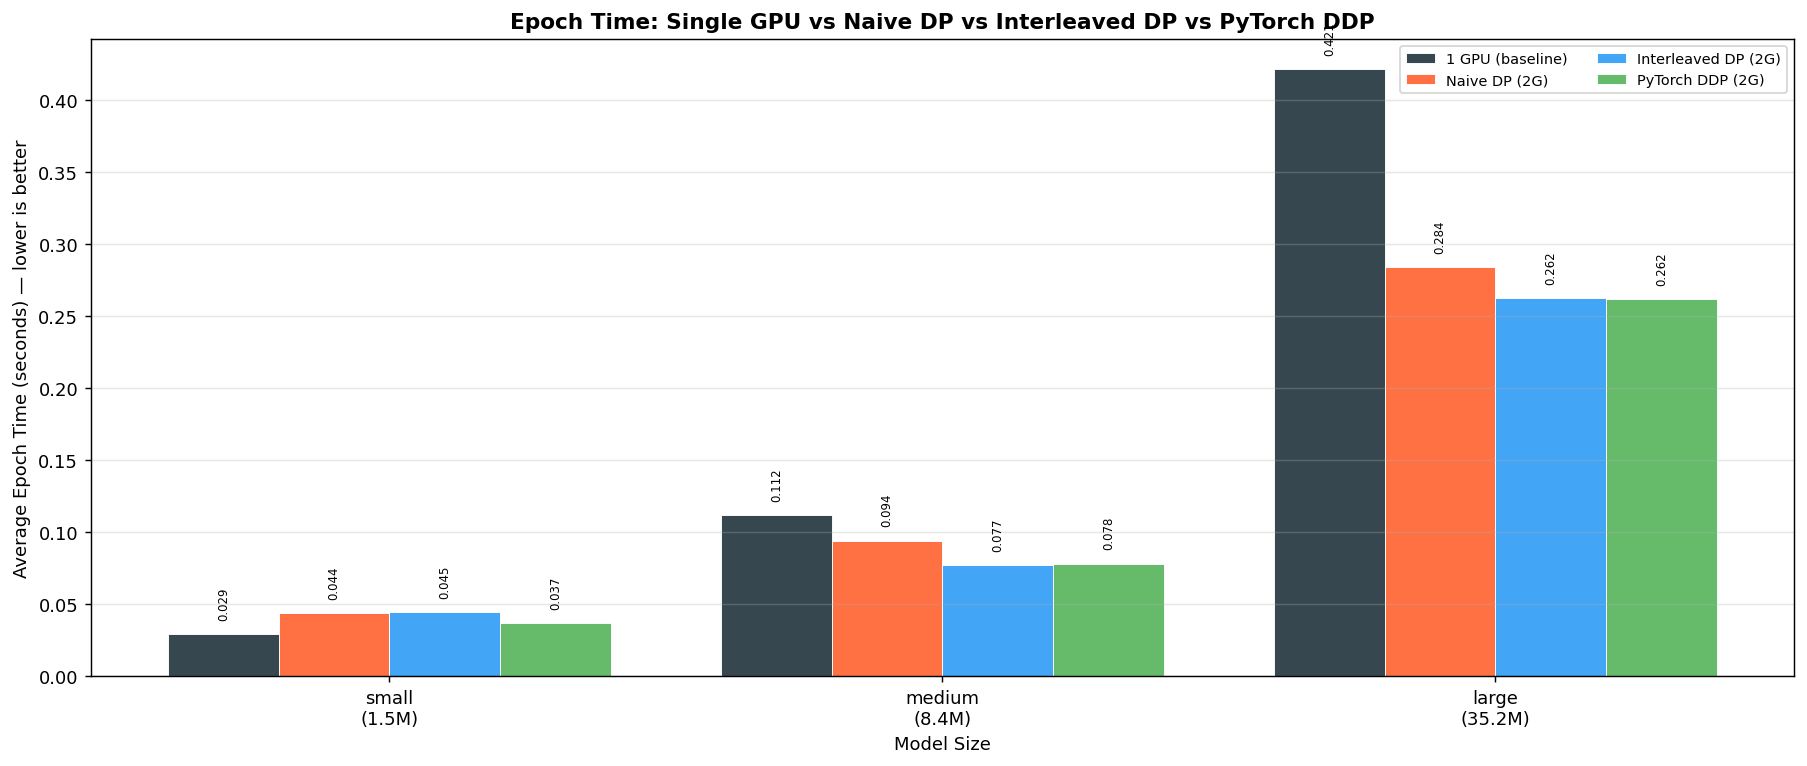

In [ ]:
# ========================================================
# CHART 1: Average Epoch Time — Grouped Bars by Model Size
# ========================================================

model_sizes_present = sorted(set(r['model_size'] for r in results),
                              key=['small','medium','large','xlarge'].index)

# Collect unique (mode, n_gpus) combos in order
combos = []
seen = set()
for r in results:
    key = (r['mode'], r['n_gpus'])
    if key not in seen:
        seen.add(key)
        combos.append(key)

colors = {
    ('single_gpu', 1): '#37474F',
    ('dp_naive', 2): '#FF7043',
    ('dp_interleaved', 2): '#42A5F5',
    ('ddp_builtin', 2): '#66BB6A',
    ('dp_naive', 4): '#FF5722',
    ('dp_interleaved', 4): '#1E88E5',
    ('ddp_builtin', 4): '#2E7D32',
}

def combo_label(mode, ng):
    names = {'single_gpu': '1 GPU (baseline)', 'dp_naive': f'Naive DP ({ng}G)',
             'dp_interleaved': f'Interleaved DP ({ng}G)', 'ddp_builtin': f'PyTorch DDP ({ng}G)'}
    return names.get(mode, f'{mode} ({ng}G)')

fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(model_sizes_present))
w = 0.8 / len(combos)

for i, (mode, ng) in enumerate(combos):
    vals = []
    for ms in model_sizes_present:
        m = [r for r in results if r['model_size'] == ms and r['mode'] == mode and r['n_gpus'] == ng]
        vals.append(m[0]['avg_epoch_time'] if m else 0)
    offset = (i - len(combos)/2 + 0.5) * w
    c = colors.get((mode, ng), f'C{i}')
    bars = ax.bar(x + offset, vals, w, label=combo_label(mode, ng), color=c,
                  edgecolor='white', linewidth=0.5)
    for bar, v in zip(bars, vals):
        if v > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{v:.3f}', ha='center', va='bottom', fontsize=6.5, rotation=90)

ax.set_xlabel('Model Size')
ax.set_ylabel('Average Epoch Time (seconds) — lower is better')
ax.set_title('Epoch Time: Single GPU vs Naive DP vs Interleaved DP vs PyTorch DDP', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f"{ms}\n({[r for r in results if r['model_size']==ms][0]['n_params']/1e6:.1f}M)"
                     for ms in model_sizes_present])
ax.legend(fontsize=8, ncol=2)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('chart1_epoch_times.png', dpi=150, bbox_inches='tight')
plt.show()

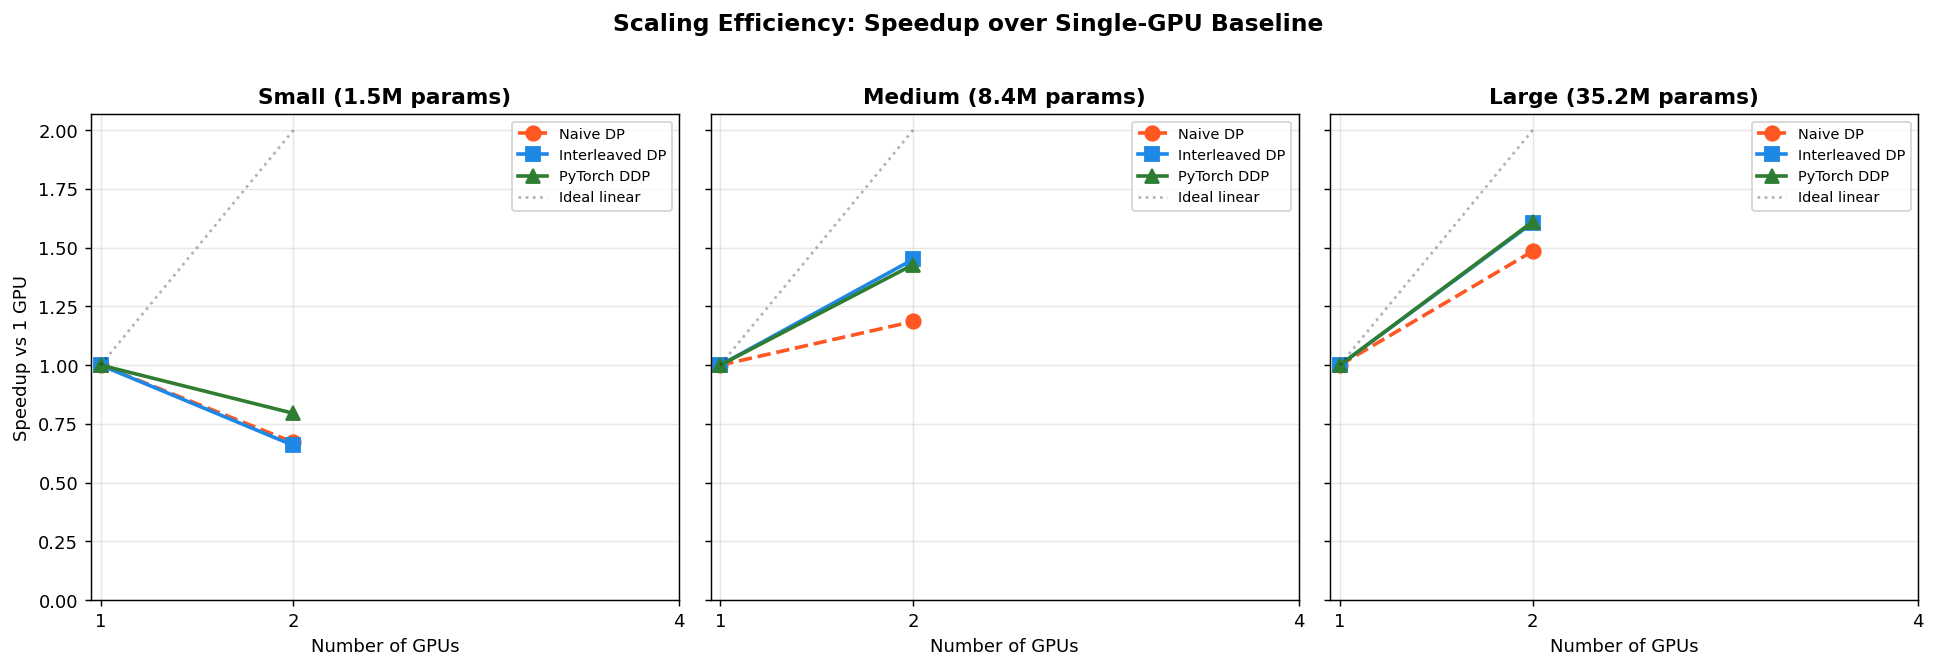

In [ ]:
# ========================================================
# CHART 2: Speedup vs Single-GPU Baseline
# ========================================================

fig, axes = plt.subplots(1, len(model_sizes_present), figsize=(5 * len(model_sizes_present), 5),
                          sharey=True)
if len(model_sizes_present) == 1:
    axes = [axes]

for idx, ms in enumerate(model_sizes_present):
    ax = axes[idx]
    baseline = [r for r in results if r['model_size'] == ms and r['mode'] == 'single_gpu']
    if not baseline:
        continue
    base_time = baseline[0]['avg_epoch_time']

    for mode, style, color, label in [
        ('dp_naive', '--o', '#FF5722', 'Naive DP'),
        ('dp_interleaved', '-s', '#1E88E5', 'Interleaved DP'),
        ('ddp_builtin', '-^', '#2E7D32', 'PyTorch DDP'),
    ]:
        gpus, speedups = [1], [1.0]
        for ng in sorted(set(r['n_gpus'] for r in results if r['mode'] == mode)):
            m = [r for r in results if r['model_size'] == ms and r['mode'] == mode and r['n_gpus'] == ng]
            if m:
                gpus.append(ng)
                speedups.append(base_time / m[0]['avg_epoch_time'])
        ax.plot(gpus, speedups, style, color=color, label=label, linewidth=2, markersize=8)

    max_g = max(r['n_gpus'] for r in results)
    ax.plot([1, max_g], [1, max_g], ':k', alpha=0.3, label='Ideal linear')
    ax.set_xlabel('Number of GPUs')
    if idx == 0:
        ax.set_ylabel('Speedup vs 1 GPU')
    n_params = baseline[0]['n_params']
    ax.set_title(f'{ms.capitalize()} ({n_params/1e6:.1f}M params)', fontweight='bold')
    ax.set_xticks([1, 2, 4][:len(set(r['n_gpus'] for r in results))+1])
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)
    ax.set_ylim(bottom=0)

fig.suptitle('Scaling Efficiency: Speedup over Single-GPU Baseline', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('chart2_speedup.png', dpi=150, bbox_inches='tight')
plt.show()

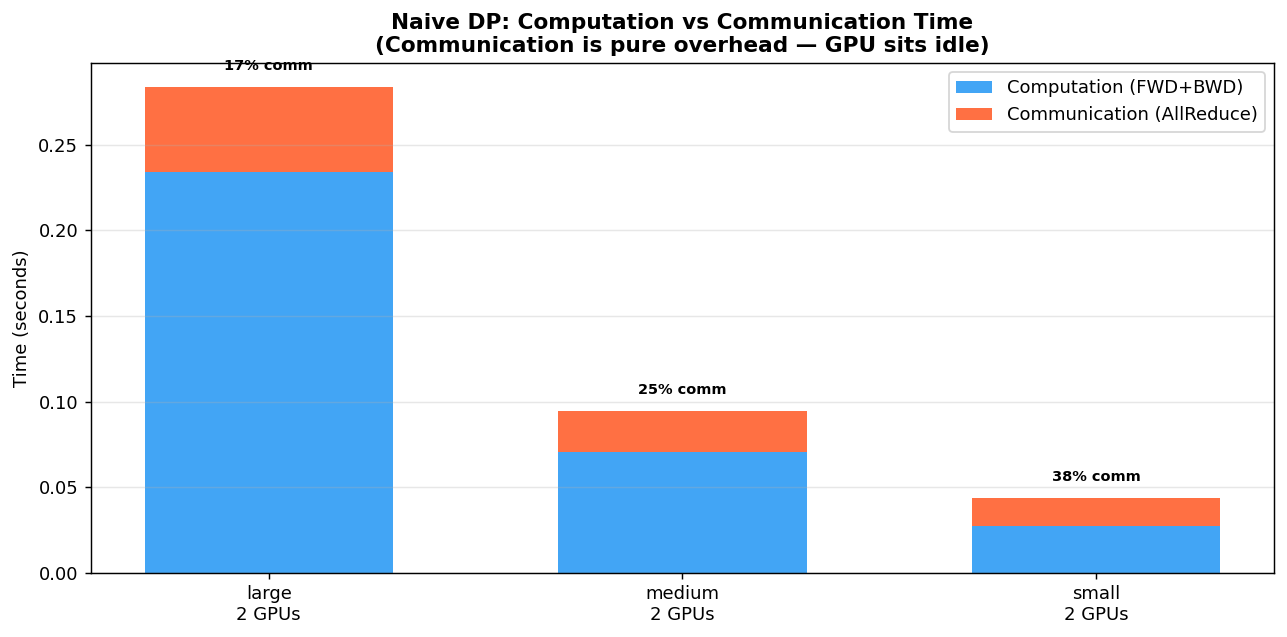

In [ ]:
# ========================================================
# CHART 3: Communication Overhead — Naive DP
# (Naive is the only one where we can cleanly measure
#  comm vs compute since they don't overlap)
# ========================================================

naive_results = [r for r in results if r['mode'] == 'dp_naive' and 'comm_times' in r]

if naive_results:
    fig, ax = plt.subplots(figsize=(10, 5))
    labels, comp, comm = [], [], []

    for r in sorted(naive_results, key=lambda x: (x['model_size'], x['n_gpus'])):
        labels.append(f"{r['model_size']}\n{r['n_gpus']} GPUs")
        avg_comm = r.get('avg_comm_time', 0)
        avg_total = r['avg_epoch_time']
        comp.append(avg_total - avg_comm)
        comm.append(avg_comm)

    x = np.arange(len(labels))
    ax.bar(x, comp, 0.6, label='Computation (FWD+BWD)', color='#42A5F5')
    ax.bar(x, comm, 0.6, bottom=comp, label='Communication (AllReduce)', color='#FF7043')

    for i, (c, cm) in enumerate(zip(comp, comm)):
        total = c + cm
        pct = cm / total * 100 if total > 0 else 0
        ax.text(i, total + 0.01, f'{pct:.0f}% comm', ha='center', fontsize=8, fontweight='bold')

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Time (seconds)')
    ax.set_title('Naive DP: Computation vs Communication Time\n(Communication is pure overhead — GPU sits idle)',
                 fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('chart3_comm_overhead.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No naive DP results with comm_times to plot.")

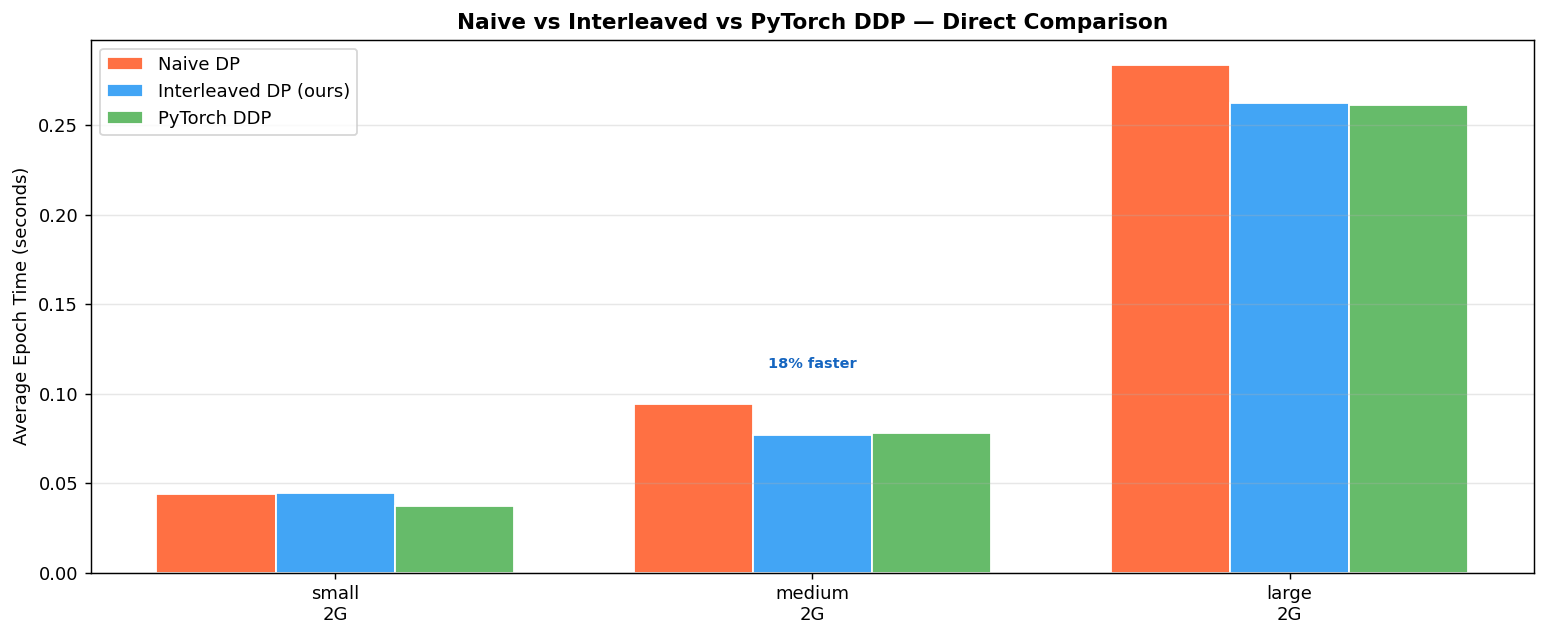

In [ ]:
# ========================================================
# CHART 4: Naive vs Interleaved — Direct Comparison
# Shows HOW MUCH time interleaving saves by overlapping
# ========================================================

fig, ax = plt.subplots(figsize=(12, 5))
pair_labels, naive_times, interl_times, ddp_times = [], [], [], []

for ms in model_sizes_present:
    for ng in sorted(set(r['n_gpus'] for r in results if r['n_gpus'] > 1)):
        n = [r for r in results if r['model_size'] == ms and r['mode'] == 'dp_naive' and r['n_gpus'] == ng]
        il = [r for r in results if r['model_size'] == ms and r['mode'] == 'dp_interleaved' and r['n_gpus'] == ng]
        dd = [r for r in results if r['model_size'] == ms and r['mode'] == 'ddp_builtin' and r['n_gpus'] == ng]
        if n and il:
            pair_labels.append(f"{ms}\n{ng}G")
            naive_times.append(n[0]['avg_epoch_time'])
            interl_times.append(il[0]['avg_epoch_time'])
            ddp_times.append(dd[0]['avg_epoch_time'] if dd else 0)

x = np.arange(len(pair_labels))
w = 0.25
ax.bar(x - w, naive_times, w, label='Naive DP', color='#FF7043', edgecolor='white')
ax.bar(x, interl_times, w, label='Interleaved DP (ours)', color='#42A5F5', edgecolor='white')
ax.bar(x + w, ddp_times, w, label='PyTorch DDP', color='#66BB6A', edgecolor='white')

# Annotate savings
for i in range(len(pair_labels)):
    if naive_times[i] > 0 and interl_times[i] > 0:
        saving = (1 - interl_times[i] / naive_times[i]) * 100
        y = max(naive_times[i], interl_times[i]) + 0.02
        if saving > 0:
            ax.annotate(f'{saving:.0f}% faster', xy=(i, y), fontsize=8,
                        ha='center', fontweight='bold', color='#1565C0')

ax.set_xticks(x)
ax.set_xticklabels(pair_labels)
ax.set_ylabel('Average Epoch Time (seconds)')
ax.set_title('Naive vs Interleaved vs PyTorch DDP — Direct Comparison', fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('chart4_naive_vs_interleaved.png', dpi=150, bbox_inches='tight')
plt.show()

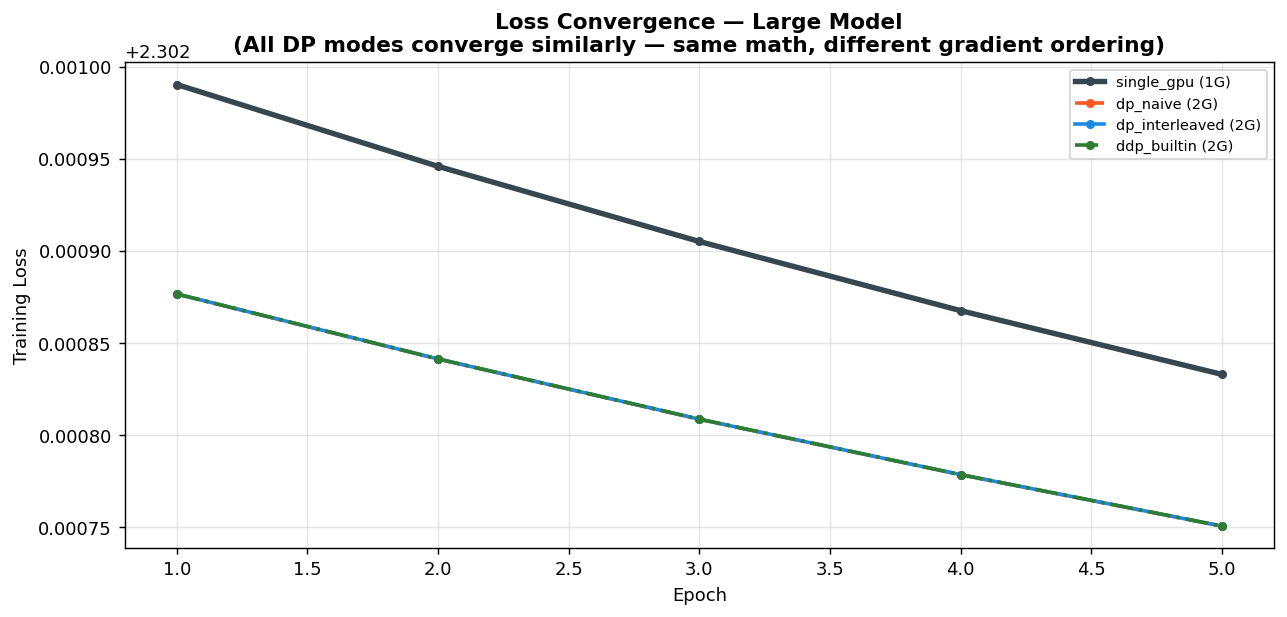

In [ ]:
# ========================================================
# CHART 5: Training Loss Convergence
# All modes should converge similarly (same math, diff ordering)
# ========================================================

# Pick the largest model for this plot
target_model = model_sizes_present[-1]

fig, ax = plt.subplots(figsize=(10, 5))
style_map = {
    'single_gpu': ('-', '#37474F', 3),
    'dp_naive': ('--', '#FF5722', 2),
    'dp_interleaved': ('-', '#1E88E5', 2),
    'ddp_builtin': ('-.', '#2E7D32', 2),
}

for r in results:
    if r['model_size'] == target_model and 'losses' in r:
        ls, c, lw = style_map.get(r['mode'], ('-', 'gray', 1))
        lbl = f"{r['mode']} ({r['n_gpus']}G)"
        ax.plot(range(1, len(r['losses'])+1), r['losses'], linestyle=ls, color=c,
                linewidth=lw, marker='o', markersize=4, label=lbl)

ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.set_title(f'Loss Convergence — {target_model.capitalize()} Model\n'
             f'(All DP modes converge similarly — same math, different gradient ordering)',
             fontweight='bold')
ax.legend(fontsize=8)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('chart5_loss_convergence.png', dpi=150, bbox_inches='tight')
plt.show()

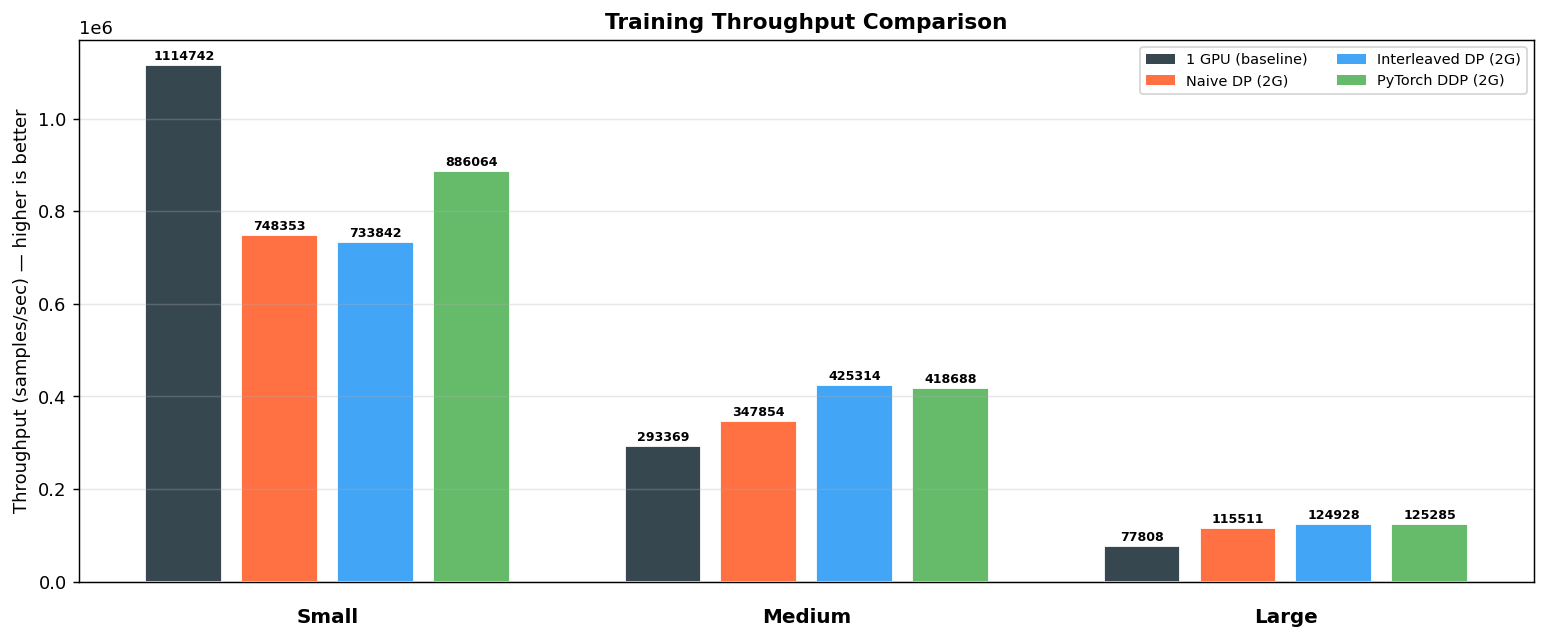

In [ ]:
# ========================================================
# CHART 6: Throughput (samples/sec) — the real metric
# ========================================================

n_samples = results[0].get('n_params', 32768)  # we stored in config
# Actually let's compute from config
N_SAMPLES = 32768  # from our config

fig, ax = plt.subplots(figsize=(12, 5))
tp_data = {}

for r in results:
    key = (r['model_size'], r['mode'], r['n_gpus'])
    throughput = N_SAMPLES / r['avg_epoch_time']
    tp_data[key] = throughput

# Group by model size
for ms_idx, ms in enumerate(model_sizes_present):
    tp_vals, tp_labels, tp_colors = [], [], []
    for mode, ng in combos:
        key = (ms, mode, ng)
        if key in tp_data:
            tp_vals.append(tp_data[key])
            tp_labels.append(combo_label(mode, ng))
            tp_colors.append(colors.get((mode, ng), f'C{len(tp_vals)}'))

    x = np.arange(len(tp_vals))
    offset = ms_idx * (len(tp_vals) + 1)
    bars = ax.bar(x + offset, tp_vals, 0.8, color=tp_colors, edgecolor='white')
    ax.text(offset + len(tp_vals)/2 - 0.5, -max(tp_data.values())*0.08, ms.capitalize(),
            ha='center', fontweight='bold', fontsize=11)
    for bar, v in zip(bars, tp_vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(tp_data.values())*0.01,
                f'{v:.0f}', ha='center', fontsize=7, fontweight='bold')

ax.set_ylabel('Throughput (samples/sec) — higher is better')
ax.set_title('Training Throughput Comparison', fontweight='bold')
ax.set_xticks([])

# Legend from combos
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors.get((m,g), 'gray'), label=combo_label(m,g))
                   for m,g in combos]
ax.legend(handles=legend_elements, fontsize=8, ncol=2)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('chart6_throughput.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5. Summary Table

In [ ]:
N_SAMPLES = 32768

print(f"\n{'Model':<8} {'Mode':<22} {'GPUs':>4} {'Params':>10} {'Epoch(s)':>9} "
      f"{'Comm(s)':>8} {'Thruput':>10} {'Speedup':>8} {'Acc':>7}")
print('─' * 95)

for ms in model_sizes_present:
    baseline = [r for r in results if r['model_size'] == ms and r['mode'] == 'single_gpu']
    base_time = baseline[0]['avg_epoch_time'] if baseline else 1.0

    for r in sorted([r for r in results if r['model_size'] == ms],
                     key=lambda x: (x['n_gpus'], x['mode'])):
        throughput = N_SAMPLES / r['avg_epoch_time']
        speedup = base_time / r['avg_epoch_time']
        comm = r.get('avg_comm_time', r.get('comm_time', 0))
        if isinstance(comm, list):
            comm = sum(comm) / len(comm)
        print(f"{r['model_size']:<8} {r['mode']:<22} {r['n_gpus']:>4} "
              f"{r['n_params']/1e6:>8.1f}M {r['avg_epoch_time']:>8.4f}s "
              f"{comm:>7.4f}s {throughput:>8.0f}/s {speedup:>7.2f}x {r['final_accuracy']:>6.4f}")
    print()


Model    Mode                   GPUs     Params  Epoch(s)  Comm(s)    Thruput  Speedup     Acc
───────────────────────────────────────────────────────────────────────────────────────────────
small    single_gpu                1      1.5M   0.0294s  0.0000s  1114742/s    1.00x 0.1022
small    ddp_builtin               2      1.5M   0.0370s  0.0000s   886064/s    0.79x 0.1013
small    dp_interleaved            2      1.5M   0.0447s  0.0000s   733842/s    0.66x 0.1013
small    dp_naive                  2      1.5M   0.0438s  0.0168s   748353/s    0.67x 0.1013

medium   single_gpu                1      8.4M   0.1117s  0.0000s   293369/s    1.00x 0.1007
medium   ddp_builtin               2      8.4M   0.0783s  0.0000s   418688/s    1.43x 0.1046
medium   dp_interleaved            2      8.4M   0.0770s  0.0000s   425314/s    1.45x 0.1046
medium   dp_naive                  2      8.4M   0.0942s  0.0236s   347854/s    1.19x 0.1046

large    single_gpu                1     35.2M   0.4211s  0.00

---
## 6. Understanding the Results

### Why Interleaved is Faster than Naive

In **naive DP**, the timeline looks like:
```
[FWD: GPU busy][BWD: GPU busy][AllReduce: NCCL busy, GPU IDLE][Update]
```
The GPU sits completely idle during AllReduce. For a model with 35M parameters on 4 GPUs, this can be 20-40% of total time wasted.

In **interleaved DP**, the timeline overlaps:
```
[FWD][BWD Layer6 → fire AllReduce(L6)][BWD Layer5 → fire AllReduce(L5)][...][Wait][Update]
      ↑ GPU computing L5 gradients       ↑ GPU computing L4 gradients
      ↑ while NCCL transfers L6 grads    ↑ while NCCL transfers L5 grads
```

### Why Deeper Models Benefit More

More layers = more opportunities to overlap. A 2-layer model has barely any backward compute to overlap with AllReduce. A 6-layer model has 5 opportunities to overlap.

### Why PyTorch DDP is Fastest

DDP adds **gradient bucketing** on top of interleaving: instead of one AllReduce per parameter tensor, it groups small tensors into ~25MB buckets and does fewer, larger AllReduces. This reduces NCCL kernel launch overhead.

### What 4 GPUs Gives You Over 2

Each GPU processes 1/4 of the batch instead of 1/2. The computation scales nearly linearly (each GPU does half the FLOPs compared to 2 GPUs). But communication increases too — Ring AllReduce requires more rounds with more nodes. The sweet spot depends on your model's **compute-to-communication ratio**.

---
## 7. RunPod Setup Guide

### How to run this on RunPod:

1. **Create a Pod** → Select a template with **2 or 4 GPUs** (e.g., `2x A100 80GB`, `4x RTX 4090`)
2. **Connect** → Open the Jupyter notebook interface
3. **Upload this notebook** and run all cells

### Recommended GPU configs to try:

| Config | Expected Behavior |
|--------|------------------|
| **2x A100** | Clear speedup. Interleaved ~15-25% faster than naive. |
| **4x A100** | Near-linear scaling for large models. Naive suffers more comm overhead. |
| **2x RTX 4090** | Good speedup. PCIe interconnect means comm overhead is higher than NVLink. |
| **4x RTX 4090** | Diminishing returns for small models. Large model scaling still good. |

### Key insight about interconnect:
- **NVLink** (A100/H100 pods): ~600 GB/s bandwidth → AllReduce is fast → naive and interleaved gap is smaller
- **PCIe** (RTX 4090 pods): ~32 GB/s bandwidth → AllReduce is slower → interleaved saves much more time

The slower the interconnect, the **more important** interleaved AllReduce becomes.